In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ComponentDataset import ComponentDataset
from BERTClassifier import BERTClassifier
from train_and_evaluate import train, evaluateModel

In [ ]:
def load_ukp_data(file_path):

    data_df = pd.read_csv(file_path, sep='\t', quoting=csv.QUOTE_NONE, encoding='utf-8')
    data_df = data_df[['topic', 'sentence', 'annotation']]
    data_df['topic'] = data_df['topic'].apply(lambda x: str(x) + ' is good')
    annotation_mapping = {'NoArgument': 2, 'Argument_for': 1, 'Argument_against': 0}
    data_df['annotation'] = data_df['annotation'].replace(annotation_mapping)
    return data_df

In [ ]:
abortion_df = load_ukp_data('abortion.tsv')
cloning_df = load_ukp_data('cloning.tsv')
death_penalty_df = load_ukp_data('death_penalty.tsv')
gun_control_df = load_ukp_data('gun_control.tsv')
marijuana_legalization_df = load_ukp_data('marijuana_legalization.tsv')
minimum_wage_df = load_ukp_data('minimum_wage.tsv')
nuclear_energy_df = load_ukp_data('nuclear_energy.tsv')
school_uniform_df = load_ukp_data('school_uniforms.tsv')
ukp_df = pd.concat([abortion_df, cloning_df, death_penalty_df, gun_control_df,
                    marijuana_legalization_df, minimum_wage_df, nuclear_energy_df, school_uniform_df], ignore_index=True)
ukp_df.head()

<ipython-input-2-8c177f1144f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['topic'] = data_df['topic'].apply(lambda x: str(x) + ' is good')


,topic,sentence,annotation
0,abortion is good,This means it has to steer monetary policy to ...,2
1,abortion is good,Where did you get that ?,2
2,abortion is good,Nathanson later became pro-life .,2
3,abortion is good,In this case we may never do evil ( directly a...,0
4,abortion is good,With that I would like to give everyone someth...,2


In [ ]:
no_df = ukp_df[ukp_df.annotation == 2]
pro_df = ukp_df[ukp_df.annotation == 1]
con_df = ukp_df[ukp_df.annotation == 0]
print(no_df.shape[0])
print(pro_df.shape[0])
print(con_df.shape[0])
con_df_downsized = con_df.sample(pro_df.shape[0])
no_df_downsized = no_df.sample(pro_df.shape[0])
ukp_df_resampled = pd.concat([pro_df, con_df_downsized, no_df_downsized], ignore_index=True)
print(ukp_df_resampled.shape[0])
ukp_df_resampled.head()

14353
4944
6195
14832


,topic,sentence,annotation
0,abortion is good,"The choice — the only actual choice , in the w...",1
1,abortion is good,But I am glad I do n't live in a society with ...,1
2,abortion is good,We have quotes from hospital documents that do...,1
3,abortion is good,Not only has the biological development not ye...,1
4,abortion is good,A mother ’s right to decide to not put her chi...,1


In [ ]:
argument1s = ukp_df_resampled['sentence'].tolist()
argument2s = ukp_df_resampled['topic'].tolist()
labels = ukp_df_resampled['annotation'].tolist()

In [ ]:
bert_model_name = 'bert-large-cased'
num_classes = 3
max_length = 512
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [ ]:
train_argument1s, val_argument1s, train_argument2s, val_argument2s,train_labels, val_labels = train_test_split(argument1s, argument2s, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = ComponentDataset(train_argument1s, train_argument2s, train_labels, tokenizer, max_length)
val_dataset = ComponentDataset(val_argument1s, val_argument2s, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluateModel(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.6953
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       989
           1       0.64      0.78      0.70      1025
           2       0.82      0.67      0.74       953

    accuracy                           0.70      2967
   macro avg       0.71      0.69      0.70      2967
weighted avg       0.71      0.70      0.70      2967

Epoch 2/4
Validation Accuracy: 0.7233
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       989
           1       0.69      0.75      0.72      1025
           2       0.75      0.76      0.75       953

    accuracy                           0.72      2967
   macro avg       0.72      0.72      0.72      2967
weighted avg       0.72      0.72      0.72      2967

Epoch 3/4
Validation Accuracy: 0.7354
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       989
           1   

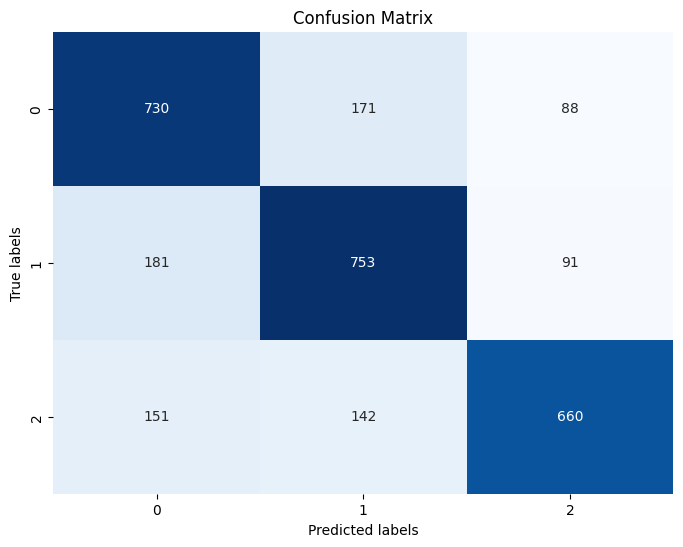

In [ ]:
def draw_confusion_matrix(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    cm = confusion_matrix(actual_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

draw_confusion_matrix(model, val_dataloader, device)

In [ ]:
model_path = 'relation.pth'
torch.save(model.state_dict(), model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>